<a href="https://colab.research.google.com/github/taraudani/linearModels-FORK/blob/main/lab_notebook_applied.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [1]:
from google.colab import files
_ = files.upload()

Saving pierce_county_house_sales.csv to pierce_county_house_sales.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('pierce_county_house_sales.csv')
df.head()

,sale_date,sale_price,house_square_feet,attic_finished_square_feet,basement_square_feet,attached_garage_square_feet,detached_garage_square_feet,fireplaces,hvac_description,exterior,interior,stories,roof_cover,year_built,bedrooms,bathrooms,waterfront_type,view_quality,utility_sewer
0,2020-01-02,380000,2157,0,0,528,0,0,Warm and Cool Air Zone,Frame Siding,Drywall,2,Composition Shingle,1993,3,3,NaN,NaN,SEWER/SEPTIC INSTALLED
1,2020-01-02,383000,2238,0,0,396,0,0,Forced Air,Frame Siding,Drywall,2,Composition Shingle,2017,4,3,NaN,NaN,SEWER/SEPTIC INSTALLED
2,2020-01-01,419900,1452,0,0,0,0,1,Forced Air,Frame Siding,Drywall,1,Built Up Rock,1965,3,2,NaN,NaN,SEWER/SEPTIC INSTALLED
3,2020-01-02,251660,832,0,0,0,0,0,Forced Air,Frame Vinyl,Drywall,1,Composition Shingle,1919,2,1,NaN,NaN,SEWER/SEPTIC INSTALLED
4,2020-01-02,500000,1780,0,384,484,0,1,Forced Air,Frame Siding,Drywall,1,Composition Shingle,1955,3,2,NaN,NaN,SEWER/SEPTIC INSTALLED


# **EDA**

In [16]:
print(df.shape)
print(df.columns)
print(df.info())

(16814, 19)
Index(['sale_date', 'sale_price', 'house_square_feet',
       'attic_finished_square_feet', 'basement_square_feet',
       'attached_garage_square_feet', 'detached_garage_square_feet',
       'fireplaces', 'hvac_description', 'exterior', 'interior', 'stories',
       'roof_cover', 'year_built', 'bedrooms', 'bathrooms', 'waterfront_type',
       'view_quality', 'utility_sewer'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16814 entries, 0 to 16813
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   sale_date                    16814 non-null  datetime64[ns]
 1   sale_price                   16814 non-null  int64         
 2   house_square_feet            16814 non-null  int64         
 3   attic_finished_square_feet   16814 non-null  int64         
 4   basement_square_feet         16814 non-null  int64         
 5   attached_garage_

In [17]:
#sale date to date time
df['sale_date'] = pd.to_datetime(df['sale_date'])

#filling in na values with 'none'
df['waterfront_type'].fillna('None', inplace=True)
df['view_quality'].fillna('None', inplace=True)

#lowercase
df['hvac_description'] = df['hvac_description'].str.lower().str.strip()
df['utility_sewer'] = df['utility_sewer'].str.lower().str.strip()
df['roof_cover'] = df['roof_cover'].str.lower().str.strip()
df['interior'] = df['interior'].str.lower().str.strip()
df['exterior'] = df['exterior'].str.lower().str.strip()

#outliers of numeric variables
numeric_cols = ['sale_price', 'house_square_feet', 'attic_finished_square_feet',
                'basement_square_feet', 'attached_garage_square_feet', 'detached_garage_square_feet',
                'fireplaces', 'stories', 'year_built', 'bedrooms', 'bathrooms']

outliers = df[numeric_cols].describe(percentiles=[0.01, 0.99])
print(outliers)

         sale_price  house_square_feet  attic_finished_square_feet  \
count  1.681400e+04       16814.000000                16814.000000   
mean   4.612332e+05        1879.941953                   24.945878   
std    2.360833e+05         760.419008                  102.066417   
min    2.000000e+03           1.000000                    0.000000   
1%     1.130434e+05         596.520000                    0.000000   
50%    4.165000e+05        1774.000000                    0.000000   
99%    1.265000e+06        3918.480000                  516.000000   
max    6.130000e+06        9510.000000                 1212.000000   

       basement_square_feet  attached_garage_square_feet  \
count          16814.000000                 16814.000000   
mean             167.852861                   364.425122   
std              429.065832                   286.454018   
min                0.000000                     0.000000   
1%                 0.000000                     0.000000   
50%      

<ipython-input-17-19c9d02f22d3>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['waterfront_type'].fillna('None', inplace=True)
<ipython-input-17-19c9d02f22d3>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

<Axes: xlabel='sale_price', ylabel='house_square_feet'>

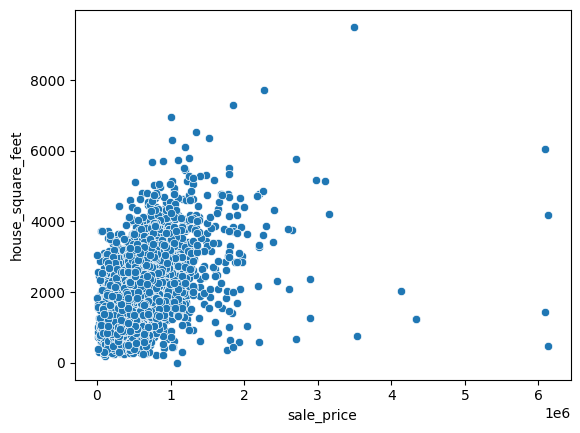

In [23]:
sns.scatterplot(data=df, x='sale_price', y='house_square_feet')

<Axes: xlabel='year_built', ylabel='sale_price'>

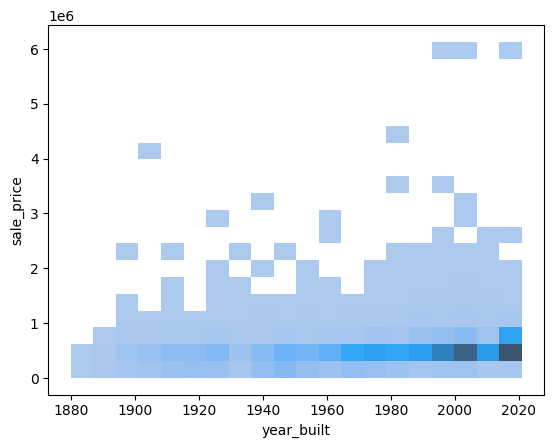

In [47]:
sns.histplot(data = df, x = 'year_built', y = 'sale_price', bins = 20)

(-1.0, 10.0)

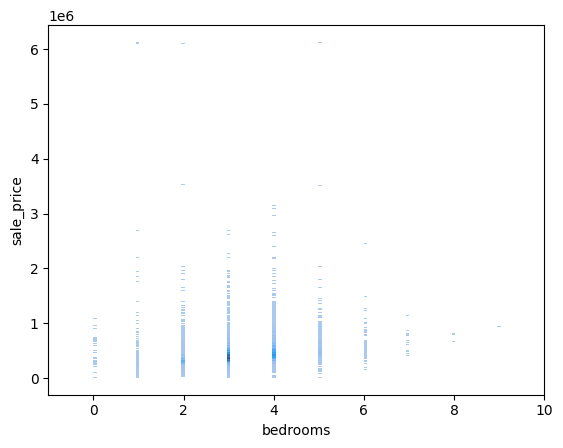

In [45]:
sns.histplot(data=df, y='sale_price', x='bedrooms')
plt.xlim(-1,10)

# **Transformation and Train Test Split**

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#selecting target variable and separating numeric/categorical (numeric is above in EDA)
target = 'sale_price'
categoric_cols = ['exterior', 'interior', 'roof_cover', 'waterfront_type', 'view_quality',
                        'hvac_description', 'utility_sewer']

#one-hot encoding categorical features
encoder = OneHotEncoder(drop='first', sparse_output = False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(df[categoric_cols])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out())

#standardizing numerical features
scaler = StandardScaler()
scaled_nums = scaler.fit_transform(df[numeric_cols])
scaled_num_df = pd.DataFrame(scaled_nums, columns=numeric_cols)

#combining transformed features
X = pd.concat([scaled_num_df, encoded_cat_df], axis=1)
y = df[target]

#splitting into 80 train 20 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((13451, 60), (3363, 60), (13451,), (3363,))

# **Linear Modeling**

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#training a simple linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

#predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

#computing RMSE and R^2 for training and test sets
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {rmse_train}, Test RMSE: {rmse_test}")
print(f"Train R²: {r2_train}, Test R²: {r2_test}")


Train RMSE: 3.040941506272923e-10, Test RMSE: 3.171281117974866e-10
Train R²: 1.0, Test R²: 1.0


Text(0.5, 1.0, 'Partial Correlation Heatmap')

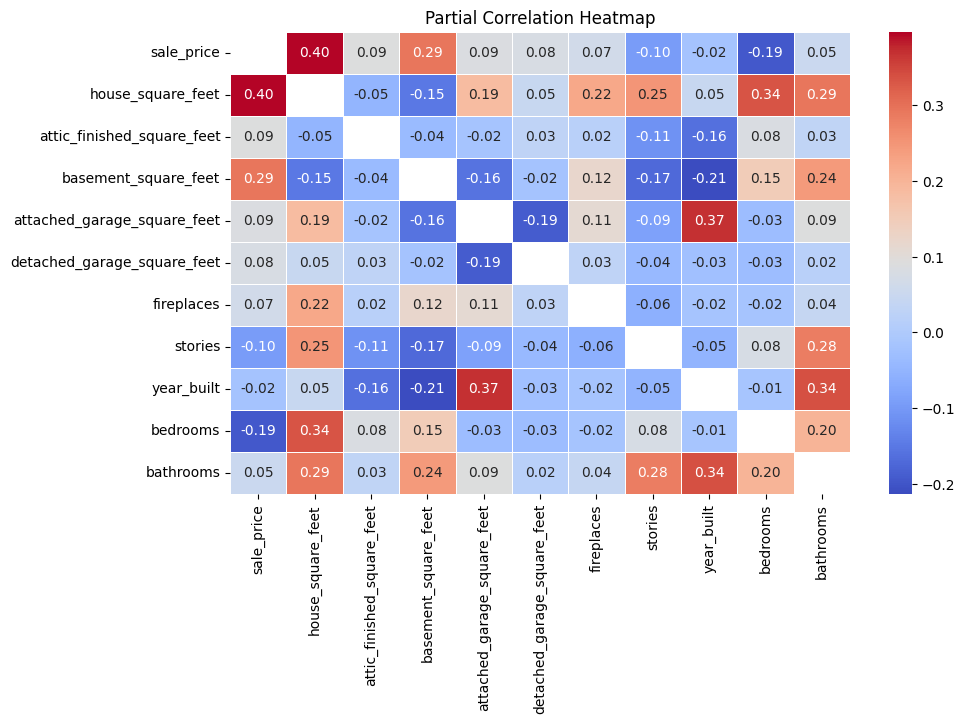

In [57]:
import pingouin as pg

#computing partial correlation matrix
partial_corr_matrix = pd.DataFrame(index=numeric_cols, columns=numeric_cols)

for var1 in numeric_cols:
    for var2 in numeric_cols:
        if var1 != var2:
            control_vars = [col for col in numeric_cols if col not in [var1, var2]]
            result = pg.partial_corr(data=df, x=var1, y=var2, covar=control_vars, method='pearson')
            partial_corr_matrix.loc[var1, var2] = result['r'].values[0]

partial_corr_matrix = partial_corr_matrix.astype(float)

#heatmap plot of partial correlations
plt.figure(figsize=(10, 6))
sns.heatmap(partial_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Partial Correlation Heatmap")